In [110]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import random
import shutil

In [11]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/rfit/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [12]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [13]:
from torchvision import transforms, datasets

In [121]:


import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader,IterableDataset
from torch.autograd import Variable

data_transform = transforms.Compose([
    
        transforms.ToTensor(),
        transforms.Resize((256,256)),
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.Lambda(lambda x: x/255)
    ])
mask_transform = transforms.Compose([
    
        transforms.ToTensor(),
        transforms.Resize((256,256)),
        transforms.Grayscale(num_output_channels=1),
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.Lambda(lambda x: x/255)
    ])

# class Transform(transform):
#     def __init__(self,vert_flip,hor_flip):
#         self.vert_flip = vert_flip
#         self.hor_flip  = hor_flip
class ImageFolderSegmentation(IterableDataset):
    """
        A generic data loader for image segmentation where the data
        are organised as:

        ....

        Parameters
        ----------
        root : str
            Root folder containing the segmentation data.
        images_path : str
            path of the images with selector
            image_path = '/image/*.png'
        label_path : str
            path of the labals with selector
        conversion : str
            conversion for input images
        transform : Composed Transformation
            transformation applied on input images
        label_transform : Composed Transformation
            transformation applied on label images

        Attributes
        ----------
        image_filenames : list of str
            images names with full path
        label_filenames : list of str
            label names with full path
        conv: list of str
            conversion List

        Examples
        --------

        >>> from dataloaderSegmentation import ImageFolderSegmentation
        >>> image_path = '/image/*.png'
        >>> label_path = '/label/*.png'
        >>> data = ImageFolderSegmentation(image_path=image_path,
        ...                                label_path=label_path)


    """

    def __init__(self, images_path, label_path, conversion='RGB',
                 transform=None,
                 label_transform=None):

        self.image_filenames = sorted(glob.glob(images_path))
        self.label_filenames = sorted(glob.glob(label_path))

        self.conversion = conversion
        for imf, lf in zip(self.image_filenames,
                                       self.label_filenames):
            if not(self._get_filename(imf) == self._get_filename(lf)):
#         if not all([self._get_filename(imf) == self._get_filename(lf)
#                     for imf, lf in zip(self.image_filenames,
#                                        self.label_filenames)]):
                raise ValueError(
                    f'Image names in Images and label have to be identical. Look {imf} and {lf}')
        self.transform = transform
        self.label_transform = label_transform

    def _get_filename(self, path):
        return os.path.basename(os.path.splitext(path)[0])

    def _pil_loader(self, path, conversion=None):
        with open(path, 'rb') as f:
            if conversion is not None:
                return Image.open(f).convert(conversion)
            else:
                return cv2.imread(path)

    def __getitem__(self, index):
        '''Get an image and a label'''

        image = self._pil_loader(path=self.image_filenames[index],
                                 conversion='RGB')
        label = self._pil_loader(path=self.label_filenames[index])

        if self.transform is not None:
            image = self.transform(image)
        if self.label_transform is not None:
            label = self.label_transform(label)
        return (image, label)

    def __len__(self):
        return len(self.image_filenames)
    def __iter__(self):
        self.value = 0
        return self
    def __next__(self):
        if self.value>=self.__len__():
            raise StopIteration
        else:
            index = self.value
            image = self._pil_loader(path=self.image_filenames[index],
                                 conversion='RGB')
            label = self._pil_loader(path=self.label_filenames[index])

            if self.transform is not None:
                image = self.transform(image)
            if self.label_transform is not None:
                label = self.label_transform(label)
            self.value+=1
            return (image, label)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp,
                                     self.transform.__repr__().replace(
                                         '\n', '\n' + ' ' * len(tmp)))
        tmp = '    Label Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp,
                                   self.label_transform.__repr__().replace(
                                       '\n', '\n' + ' ' * len(tmp)))
        return fmt_str


In [16]:
data_train = ImageFolderSegmentation('../resize_images/*','../marking/*',None,
                               transform = data_transform,label_transform = mask_transform)
data_val = ImageFolderSegmentation('../resize_images_val/*','../marking_val/*',None,
                               transform = data_transform,label_transform = mask_transform)
print(len(data_train),len(data_val))

164 16


In [17]:
data_val[0][1].max()

tensor(0.9999)

In [18]:
train = DataLoader(data_train, batch_size=16, shuffle=False)
val = DataLoader(data_val, batch_size=16, shuffle=False)

In [19]:
def ten2im(im):
    return np.transpose(im,(1,2,0))

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

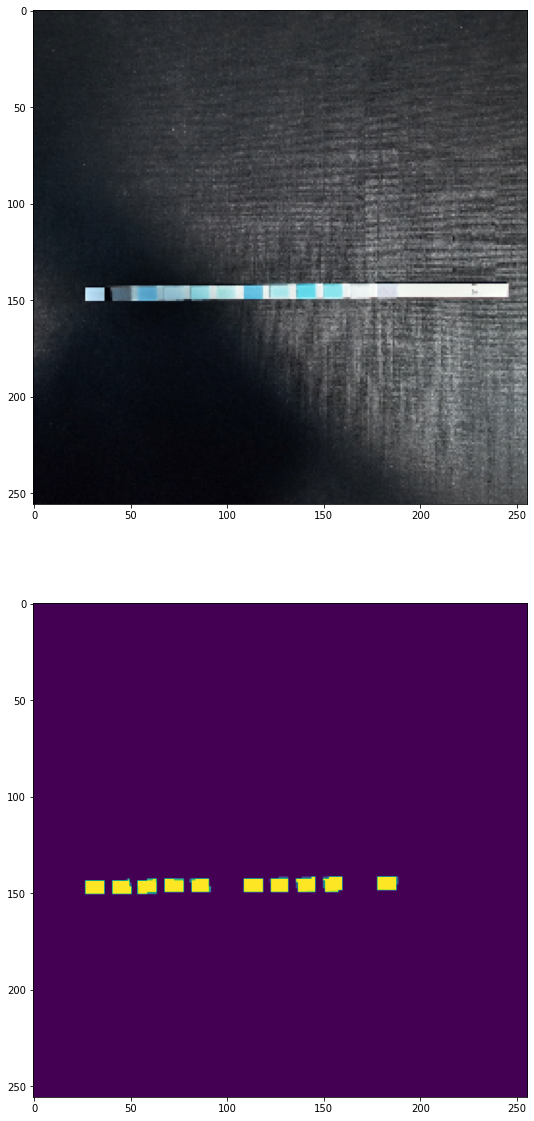

In [62]:
fig,ax = plt.subplots(2,1,figsize=(10,20))
ax[0].imshow(ten2im(data_train[94][0]))
ax[1].imshow(ten2im(data_train[94][1]))
data_train[21][0].shape,data_train[21][1].shape

In [44]:
np.array(ten2im(data_val[-1][1]),dtype=np.float).max()

0.9999000430107117

In [54]:
for i in range(len(data_train)):
    contours, hierarchy =cv2.findContours(np.array(ten2im(data_train[i][1]*255),dtype= np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(i,len(contours))

0 12
1 14
2 17
3 13
4 12
5 14
6 12
7 13
8 12
9 14
10 14
11 12
12 15
13 12
14 12
15 13
16 12
17 12
18 12
19 12
20 15
21 13
22 13
23 14
24 13
25 14
26 13
27 13
28 12
29 12
30 12
31 13
32 13
33 13
34 13
35 12
36 13
37 12
38 12
39 12
40 12
41 13
42 12
43 12
44 12
45 12
46 12
47 12
48 12
49 13
50 15
51 12
52 12
53 13
54 13
55 11
56 11
57 14
58 12
59 14
60 12
61 13
62 12
63 12
64 12
65 12
66 13
67 13
68 13
69 14
70 13
71 12
72 14
73 12
74 18
75 12
76 12
77 13
78 14
79 13
80 15
81 7
82 16
83 14
84 16
85 12
86 12
87 14
88 13
89 13
90 14
91 12
92 0
93 12
94 10
95 16
96 11
97 13
98 13
99 12
100 10
101 12
102 12
103 11
104 12
105 14
106 13
107 12
108 12
109 13
110 14
111 12
112 13
113 17
114 17
115 13
116 14
117 14
118 12
119 16
120 20
121 12
122 12
123 13
124 12
125 12
126 12
127 12
128 12
129 12
130 12
131 12
132 12
133 12
134 13
135 12
136 12
137 11
138 13
139 12
140 12
141 12
142 13
143 12
144 14
145 12
146 12
147 15
148 12
149 12
150 13
151 14
152 12
153 11
154 13
155 12
156 12
157 0
158 11


In [24]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter(log_dir='log_dir')

In [148]:
for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [140]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/rfit/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [26]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)
optimizer = torch.optim.Adam(model.parameters())
loss_fun = diceloss()
num_epochs = 100
device= 'cuda'
model.to(device)
for ep in range(num_epochs):
    train_loss=0
    for (i,l) in train:
#         print('teain',i.max(),l.max())
        model.train()
#         print(i.shape,l.shape)
        optimizer.zero_grad()
        i= i.to(device)
        l = l.to(device)
#         l=l.long()
        outt = model(i)
#         pred = torch.Variable(torch.argmax(outt['out'],1).float(),requires_grad=True).cuda()
        pred=outt
#         print(pred.shape,l.shape)
        loss = loss_fun(pred,l.type(torch.cuda.FloatTensor))
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        print(loss,end ='\r')
    writer.add_scalar('Loss train',train_loss/(len(val)),ep)
    val_loss=0
    model.eval()
    images =[]
    labels = []
    for (i_v,l_v) in val:
#         print('val',i_v.max(),l_v.max())
        with torch.no_grad():
            i_v=i_v.to(device)
            l_v = l_v.to(device)
#             l_v=l_v.long()
            outt = model(i_v)
#             pred = Variable(torch.argmax(outt['out'],1).float(),requires_grad=True).cuda()
            pred=outt
    #         print(pred.shape,l.shape)
            loss = loss_fun(pred,l_v.type(torch.cuda.FloatTensor))
            val_loss+=loss.item()
    writer.add_scalar('Loss val',val_loss/(len(val)),ep)
    writer.add_scalar('Loss train',val_loss/(len(val)),ep)
    print(f'vaidation mean loss is:{val_loss/(len(val))} in {ep} epoch')
            
    
#     print(ep,outt)
# torch.save(model, 'models/newnet.pth')

vaidation mean loss is:0.9465345144271851 in 0 epochd1>)
vaidation mean loss is:0.8675901889801025 in 1 epochd1>)
vaidation mean loss is:0.6400836706161499 in 2 epochd1>)
vaidation mean loss is:0.6051841974258423 in 3 epochd1>)
vaidation mean loss is:0.7108412981033325 in 4 epochd1>)
vaidation mean loss is:0.6354236602783203 in 5 epochd1>)
vaidation mean loss is:0.808521032333374 in 6 epochrd1>)
vaidation mean loss is:0.8973143100738525 in 7 epochd1>)
vaidation mean loss is:0.588617205619812 in 8 epochrd1>)
vaidation mean loss is:0.8485425710678101 in 9 epochd1>)
vaidation mean loss is:0.9237642288208008 in 10 epoch1>)
vaidation mean loss is:0.9236692786216736 in 11 epoch1>)
vaidation mean loss is:0.9433272480964661 in 12 epoch1>)
vaidation mean loss is:0.5732580423355103 in 13 epoch1>)
vaidation mean loss is:0.9616387486457825 in 14 epoch1>)
vaidation mean loss is:0.8787981867790222 in 15 epoch1>)
vaidation mean loss is:0.9500333666801453 in 16 epoch1>)
vaidation mean loss is:0.884009

KeyboardInterrupt: 

In [28]:
import time

In [29]:
val_loss=0
model.eval()
device= 'cpu'
model.to(device)
for (i_v,l_v) in val:
    print('val',i_v.max(),l_v.max())
    with torch.no_grad():
        i_v=i_v.to(device)
        l_v = l_v.to(device)
#         l_v=l_v.long()
#         print(l_v.max())
        s= time.time()
        outt = model(i_v)
#             pred = Variable(torch.argmax(outt['out'],1).float(),requires_grad=True).cuda()
        print(time.time()-s)
        pred=outt
#         print(pred.shape,l.shape)
        loss = loss_fun(pred,l_v)
        val_loss+=loss.item()
print(f'vaidation mean loss is:{val_loss/(len(val))}')

val tensor(1.) tensor(0.9999)
1.4693057537078857
vaidation mean loss is:0.3364063501358032


In [30]:
i_v.shape,l_v.shape,pred.shape

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 1, 256, 256]),
 torch.Size([16, 1, 256, 256]))

In [31]:
np.array(l_v.cpu()).max()

0.99990004

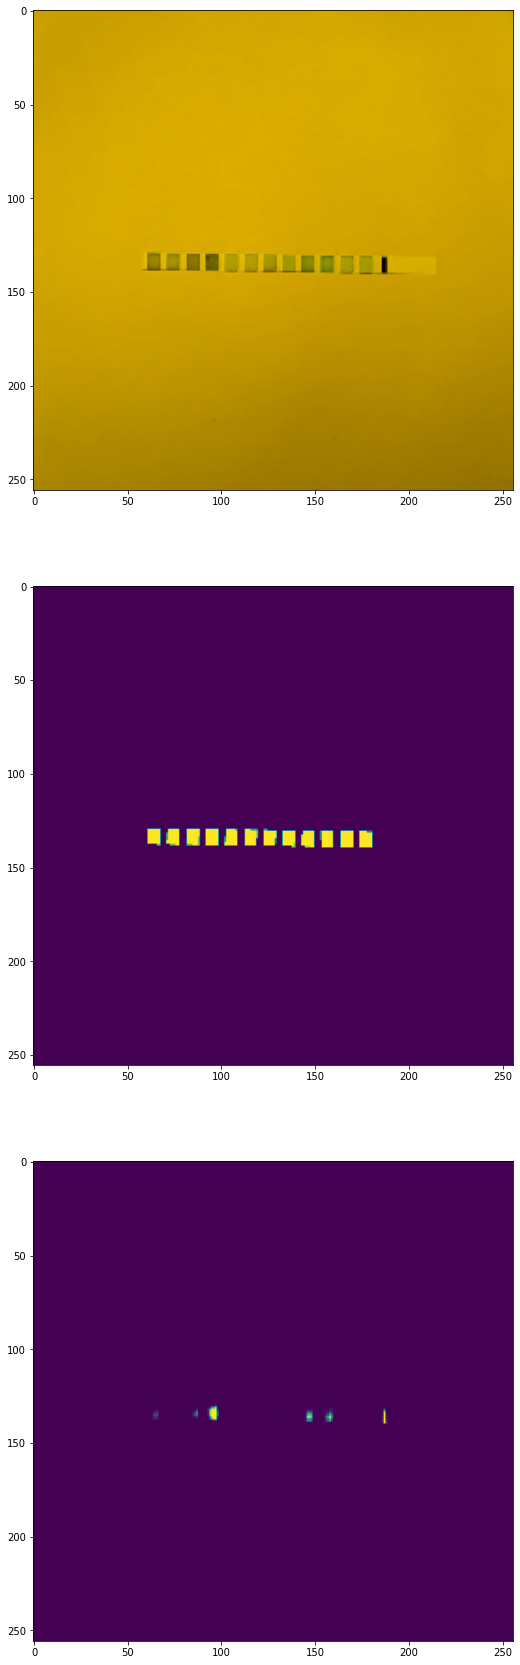

In [34]:
i=11
fig,ax = plt.subplots(3,1,figsize=(10,30))
ax[0].imshow(ten2im(np.array(i_v[i].cpu())))
ax[1].imshow(ten2im(np.array(l_v[i].cpu())))
ax[2].imshow(ten2im(np.array(pred[i].cpu())))

In [33]:
i=21
im= ten2im(np.array(data_val[i][0].cpu()))
mask = ten2im(np.array(data_val[i][1].cpu()))
m_im = np.where(mask>0.7,im,0)
plt.figure(figsize=(10,10))
plt.imshow(m_im)

IndexError: list index out of range

In [22]:
class TestDataset(IterableDataset):
    """
        A generic data loader for image segmentation where the data
        are organised as:

        ....

        Parameters
        ----------
        root : str
            Root folder containing the segmentation data.
        images_path : str
            path of the images with selector
            image_path = '/image/*.png'
        label_path : str
            path of the labals with selector
        conversion : str
            conversion for input images
        transform : Composed Transformation
            transformation applied on input images
        label_transform : Composed Transformation
            transformation applied on label images

        Attributes
        ----------
        image_filenames : list of str
            images names with full path
        label_filenames : list of str
            label names with full path
        conv: list of str
            conversion List

        Examples
        --------

        >>> from dataloaderSegmentation import ImageFolderSegmentation
        >>> image_path = '/image/*.png'
        >>> label_path = '/label/*.png'
        >>> data = ImageFolderSegmentation(image_path=image_path,
        ...                                label_path=label_path)


    """

    def __init__(self, images_path, label_path, conversion='RGB',
                 transform=None,
                 label_transform=None):

        self.image_filenames = sorted(glob.glob(images_path))

        self.conversion = conversion
        self.transform = transform
        self.label_transform = label_transform

    def _get_filename(self, path):
        return os.path.basename(os.path.splitext(path)[0])

    def _pil_loader(self, path, conversion=None):
        with open(path, 'rb') as f:
            if conversion is not None:
                return Image.open(f).convert(conversion)
            else:
                return cv2.imread(path)

    def __getitem__(self, index):
        '''Get an image and a label'''

        image = self._pil_loader(path=self.image_filenames[index],
                                 conversion='RGB')

        if self.transform is not None:
            image = self.transform(image)
        
        return (image)

    def __len__(self):
        return len(self.image_filenames)
    def __iter__(self):
        self.value = 0
        return self
    def __next__(self):
        if self.value>=self.__len__():
            raise StopIteration
        else:
            index = self.value
            image = self._pil_loader(path=self.image_filenames[index],
                                 conversion='RGB')

            if self.transform is not None:
                image = self.transform(image)
            self.value+=1
            return (image, label)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp,
                                     self.transform.__repr__().replace(
                                         '\n', '\n' + ' ' * len(tmp)))
        return fmt_str


In [125]:
test = TestDataset('../data/not_used(test)/*',None,
                               transform = data_transform)
test

Dataset TestDataset
    Number of datapoints: 3
    Transforms (if any): Compose(
                             ToTensor()
                             Resize(size=(256, 256), interpolation=bilinear)
                         )

In [127]:
model.eval()
model.cuda()
with torch.no_grad():
    im = test[0].unsqueeze((0)).cuda()
    pred = model(im)
    im = im.cpu()
    pred = pred.cpu()

In [128]:
pred

tensor([[[[3.3441e-05, 8.6078e-06, 1.1653e-05,  ..., 7.2351e-06,
           9.2757e-06, 3.6254e-05],
          [4.4780e-05, 1.1777e-06, 3.1722e-06,  ..., 2.3110e-06,
           3.1263e-06, 3.0641e-05],
          [5.8650e-05, 2.3301e-07, 4.2126e-07,  ..., 3.0480e-07,
           8.2893e-07, 1.3660e-05],
          ...,
          [9.0561e-05, 2.7743e-07, 9.0344e-07,  ..., 6.0621e-08,
           1.7185e-07, 1.2329e-05],
          [1.1560e-04, 1.5362e-06, 5.7178e-06,  ..., 5.6837e-07,
           8.8227e-07, 2.4631e-05],
          [4.5287e-05, 5.4639e-06, 8.5279e-06,  ..., 2.6117e-06,
           3.6843e-06, 2.6600e-05]]]])

# my data


In [100]:
# making marked
os.mkdir('../data/seegmentation/masks/train')
os.mkdir('../data/seegmentation/masks/val')

In [102]:
for im_n in glob.glob('../data/seegmentation/images/train/*'):
    im = cv2.imread(im_n)
    print(im_n,im.shape)
    mask= np.zeros_like(im)
    l_n= im_n.replace('images','labels').replace('jpg','txt').replace('jpeg','txt')
    with open(l_n) as f:
        data=f.readlines()
        for rec in data:
            _,x0,y0,w,h=[float(i) for i  in rec.split()]
            x1=int((x0-w/2)*im.shape[1])
            x2=int((x0+w/2)*im.shape[1])
            
            y1=int((y0-h/2)*im.shape[0])
            y2=int((y0+h/2)*im.shape[0])
            mask[y1:y2,x1:x2] = 255
    cv2.imwrite(im_n.replace('images','masks'),mask)

../data/seegmentation/images/train/2024-02-15 22_20_50.751_20240126_083009.jpg (4000, 3000, 3)
../data/seegmentation/images/train/1_IMG_5910.jpeg (3024, 4032, 3)
../data/seegmentation/images/train/2024-02-15 22_53_14.226_20240210_180520.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_46_28.744_20240117_162444.jpg (4000, 3000, 3)
../data/seegmentation/images/train/1_IMG_5884.jpeg (3024, 4032, 3)
../data/seegmentation/images/train/2024-02-15 22_27_29.018_20240117_162336.jpg (4000, 3000, 3)
../data/seegmentation/images/train/1_IMG_5894.jpeg (4032, 3024, 3)
../data/seegmentation/images/train/2024-02-15 22_51_34.210_20240117_162443.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_17_59.462_20240126_083120.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_17_59.462_20240126_083122.jpg (4000, 3000, 3)
../data/seegmentation/images/train/1_IMG_5877.jpeg (4032, 3024, 3)
../data/seegmentation/images/train/2_IMG_5897.jpeg (4032, 3024, 3)


../data/seegmentation/images/train/2024-02-15 22_53_14.226_20240210_180417.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_53_14.226_20240210_180233.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_17_59.462_20240126_083125.jpg (4000, 3000, 3)
../data/seegmentation/images/train/1_IMG_5895.jpeg (4032, 3024, 3)
../data/seegmentation/images/train/2024-02-15 22_53_14.226_20240210_180611.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_46_28.744_20240117_162306.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_53_14.226_20240210_180628.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_27_29.018_20240117_162342.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_13_22.061_20240126_082523.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_20_50.751_20240126_082944.jpg (4000, 3000, 3)
../data/seegmentation/images/train/2024-02-15 22_15_13.357_20240126_082503.jpg

In [119]:
# print(len(glob('../data/seegmentation/masks/train/*')))
# l=glob('../data/seegmentation/masks/train/*')
# val = random.choices(l,k=15)
# for im in val:
#     shutil.move(im,im.replace('train','val'))
#     im_2=im.replace('jpg','txt').replace('jpeg','txt').replace('images','labels')
#     shutil.move(im_2,im_2.replace('train','val'))
# for im in val:
#     im=im.replace('seegmentation','detection').replace('masks','images')
#     shutil.move(im,im.replace('train','val'))
#     im_2=im.replace('jpg','txt').replace('jpeg','txt').replace('images','labels')
#     shutil.move(im_2,im_2.replace('train','val'))

In [210]:
data_train = ImageFolderSegmentation('../data/seegmentation/images/train/*','../data/seegmentation/masks/train/*',None,
                               transform = data_transform,label_transform = mask_transform)
data_val = ImageFolderSegmentation('../data/seegmentation/images/val/*','../data/seegmentation/masks/val/*',None,
                               transform = data_transform,label_transform = mask_transform)
print(len(data_train),len(data_val))

166 15


In [423]:
import os
import glob
from PIL import Image
import torch 
from torch.utils.data import Dataset,DataLoader,IterableDataset
from torch.autograd import Variable
class rotation():
    def __init__(self,angle):
        self.angle = angle
    def __call__(self,sample):
        return transforms.functional.rotate(sample, self.angle)
rot = rotation(270)

data_transform = transforms.Compose([
    
        transforms.ToTensor(),
        transforms.Resize((256,256)),
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda x: x/255)
    ])
mask_transform = transforms.Compose([
    
        transforms.ToTensor(),
        transforms.Resize((256,256)),
#         transforms.Grayscale(num_output_channels=1),
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda x: x/255)
    ])

class gloabal_transform():
    def __call__(self,image,mask):
        image = data_transform(image)
#         image = rot(image)
        mask = mask_transform(mask)
        p_flip_h = np.random.uniform(0,1,1)
#         print(image.shape)
#         print('flipping')
#         if p_flip_h>0.5:
#             print('h_flip')
#             mask = transforms.functional.hflip(mask)
#             image = transforms.functional.hflip(image)
#         p_flip_v = np.random.uniform(0,1,1)
#         if p_flip_v>0.5:
#             print('v_flip')
#             mask = transforms.functional.vflip(mask)
#             image = transforms.functional.vflip(image)
        mask = transforms.functional.rgb_to_grayscale(mask)
        return image,mask
G_transform = gloabal_transform()
class ImageFolderSegmentation(IterableDataset):

    def __init__(self, images_path, label_path, conversion='RGB',
                 transform=None,
                 label_transform=None):

        self.image_filenames = sorted(glob.glob(images_path))
        self.label_filenames = sorted(glob.glob(label_path))

        self.conversion = conversion
        for imf, lf in zip(self.image_filenames,
                                       self.label_filenames):
            if not(self._get_filename(imf) == self._get_filename(lf)):
#         if not all([self._get_filename(imf) == self._get_filename(lf)
#                     for imf, lf in zip(self.image_filenames,
#                                        self.label_filenames)]):
                raise ValueError(
                    f'Image names in Images and label have to be identical. Look {imf} and {lf}')
        self.transform = transform
        self.label_transform = label_transform

    def _get_filename(self, path):
        return os.path.basename(os.path.splitext(path)[0])

    def _pil_loader(self, path, conversion=None):
        with open(path, 'rb') as f:
            if conversion is not None:
                return np.array(cv2.imread(path),dtype=np.float32)
            else:
                return np.array(cv2.imread(path),dtype=np.float32)

    def __getitem__(self, index):
        '''Get an image and a label'''

        image = self._pil_loader(path=self.image_filenames[index])
        label = self._pil_loader(path=self.label_filenames[index])
#         label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
#         if self.transform is not None:
#             image = self.transform(image)
#         if self.label_transform is not None:
#             label = self.label_transform(label)
        image,label = G_transform(image,label)
        return (image, label)

    def __len__(self):
        return len(self.image_filenames)
    def __iter__(self):
        self.value = 0
        return self
    def __next__(self):
        if self.value>=self.__len__():
            raise StopIteration
        else:
            index = self.value
            image = self._pil_loader(path=self.image_filenames[index])
            label = self._pil_loader(path=self.label_filenames[index])

#             if self.transform is not None:
#                 image = self.transform(image)
#             if self.label_transform is not None:
#                 label = self.label_transform(label)
            self.value+=1
            image,label = G_transform(image,label)
            return (image, label)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp,
                                     self.transform.__repr__().replace(
                                         '\n', '\n' + ' ' * len(tmp)))
        tmp = '    Label Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp,
                                   self.label_transform.__repr__().replace(
                                       '\n', '\n' + ' ' * len(tmp)))
        return fmt_str


../data/seegmentation/images/train/1_IMG_5901.jpeg ../data/seegmentation/masks/train/1_IMG_5901.jpeg
torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


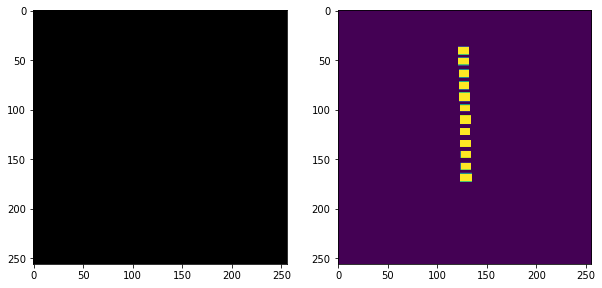

In [424]:
i_path = glob.glob('../data/seegmentation/images/train/*') 
m_path = glob.glob('../data/seegmentation/masks/train/*') 
i=51
print(i_path[i],m_path[i])
im=cv2.imread(i_path[i])
m=cv2.imread(m_path[i])
m=cv2.imread(m_path[i])
im,m = G_transform(im,m)
print(im.shape,m.shape)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(ten2im(im))
ax[1].imshow(ten2im(m))

In [425]:
data_train = ImageFolderSegmentation('../data/seegmentation/images/train/*','../data/seegmentation/masks/train/*',None,
                               transform = data_transform,label_transform = mask_transform)
data_val = ImageFolderSegmentation('../data/seegmentation/images/val/*','../data/seegmentation/masks/val/*',None,
                               transform = data_transform,label_transform = mask_transform)
print(len(data_train),len(data_val))

166 15


In [426]:
train = DataLoader(data_train, batch_size=16, shuffle=False)
val = DataLoader(data_val, batch_size=16, shuffle=False)

(tensor(1.), tensor(0.9999))

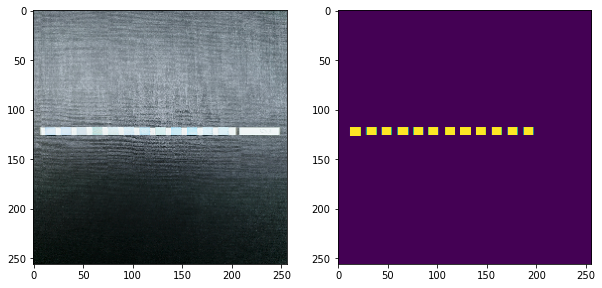

In [427]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(ten2im(data_train[100][0]))
ax[1].imshow(ten2im(data_train[100][1]))
data_train[21][0].max(),data_train[21][1].max()

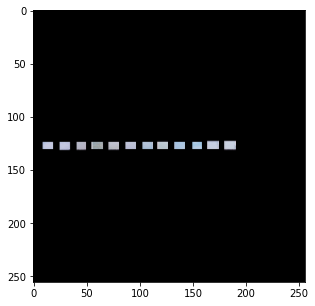

In [428]:
plt.figure(figsize=(5,5))
plt.imshow(ten2im(data_train[50][1])*ten2im(data_train[50][0]))

In [429]:
writer = SummaryWriter(log_dir='log_dir/change')

In [431]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)
optimizer = torch.optim.Adam(model.parameters())
loss_fun = diceloss()
num_epochs = 100
device= 'cuda'
model.to(device)
for ep in range(num_epochs):
    train_loss=0
    for (i,l) in train:
#         print('teain',i.max(),l.max())
        model.train()
#         print(i.shape,l.shape)
        optimizer.zero_grad()
        i= i.to(device)
        l = l.to(device)
#         l=l.long()
        outt = model(i)
#         pred = torch.Variable(torch.argmax(outt['out'],1).float(),requires_grad=True).cuda()
        pred=outt
#         print(pred.shape,l.shape)
        loss = loss_fun(pred,l.type(torch.cuda.FloatTensor))
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        print(loss,end ='\r')
    writer.add_scalar('Loss train',train_loss/(len(train)),ep)
    val_loss=0
    model.eval()
    images =[]
    labels = []
    for (i_v,l_v) in val:
#         print('val',i_v.max(),l_v.max())
        with torch.no_grad():
            i_v=i_v.to(device)
            l_v = l_v.to(device)
#             l_v=l_v.long()
            outt = model(i_v)
#             pred = Variable(torch.argmax(outt['out'],1).float(),requires_grad=True).cuda()
            pred=outt
    #         print(pred.shape,l.shape)
            loss = loss_fun(pred,l_v.type(torch.cuda.FloatTensor))
            val_loss+=loss.item()
    writer.add_scalar('Loss val',val_loss/(len(val)),ep)
    writer.add_scalar('Loss train',val_loss/(len(val)),ep)
    print(f'vaidation mean loss is:{val_loss/(len(val))} in {ep} epoch')
            
    
#     print(ep,outt)
# torch.save(model, 'models/newnet.pth')

Using cache found in /home/rfit/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


vaidation mean loss is:0.658848762512207 in 0 epochrd1>)
vaidation mean loss is:0.5376615524291992 in 1 epochd1>)
vaidation mean loss is:0.5277290940284729 in 2 epochd1>)
vaidation mean loss is:0.894485592842102 in 3 epochrd1>)
vaidation mean loss is:0.4390600919723511 in 4 epochd1>)
vaidation mean loss is:0.49323511123657227 in 5 epoch1>)
vaidation mean loss is:0.41451263427734375 in 6 epoch1>)
vaidation mean loss is:0.3921343684196472 in 7 epochd1>)
vaidation mean loss is:0.35051339864730835 in 8 epoch1>)
vaidation mean loss is:0.3882399797439575 in 9 epochd1>)
vaidation mean loss is:0.32174110412597656 in 10 epoch>)
vaidation mean loss is:0.5935455560684204 in 11 epoch1>)
vaidation mean loss is:0.46057212352752686 in 12 epoch>)


KeyboardInterrupt: 

In [432]:
val_loss=0
model.eval()
device= 'cpu'
model.to(device)
for (i_v,l_v) in val:
    print('val',i_v.max(),l_v.max())
    with torch.no_grad():
        i_v=i_v.to(device)
        l_v = l_v.to(device)
#         l_v=l_v.long()
#         print(l_v.max())
        s= time.time()
        outt = model(i_v)
#             pred = Variable(torch.argmax(outt['out'],1).float(),requires_grad=True).cuda()
        print(time.time()-s)
        pred=outt
#         print(pred.shape,l.shape)
        loss = loss_fun(pred,l_v)
        val_loss+=loss.item()
print(f'vaidation mean loss is:{val_loss/(len(val))}')

val tensor(1.) tensor(0.9999)
1.2550232410430908
vaidation mean loss is:0.4290975332260132


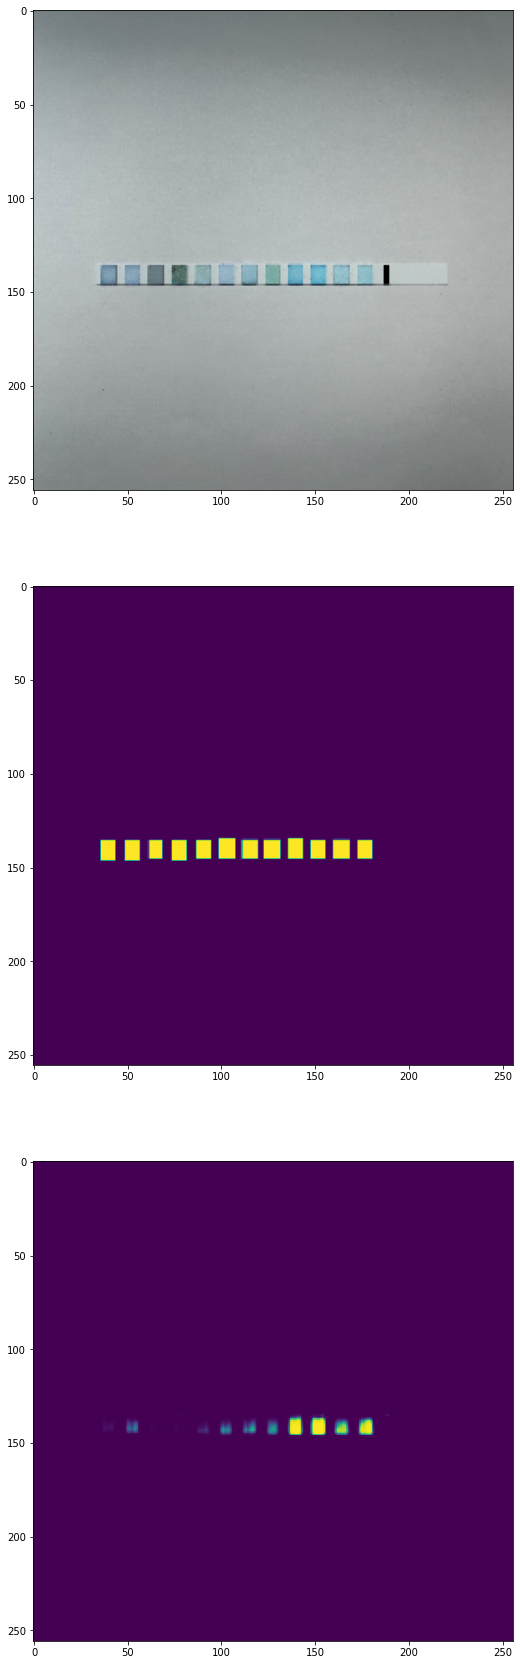

In [436]:
i=-1
fig,ax = plt.subplots(3,1,figsize=(10,30))
ax[0].imshow(ten2im(np.array(i_v[i].cpu())))
ax[1].imshow(ten2im(np.array(l_v[i].cpu())))
ax[2].imshow(ten2im(np.array(pred[i].cpu())))